In [ ]:
"""
Prepare TED dataset for tuning ImageBindLora model
"""

In [ ]:
# https://github.com/jin-s13/COCO-WholeBody

In [2]:
import pandas as pd
import pickle
import re

import numpy as np
from sklearn.metrics import pairwise_distances
import torch
import os
from tqdm import tqdm

import cv2

from PIL import Image, ImageDraw

/home/vash/miniconda3/envs/ImageBind/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base = '/media/storage/datasets/youtube-gesture-dataset/TED_clips_DS/clips_ds'

# For getting keypoints I used scrip: /home/vash/apps/avatar/mmpose/get_landmarks.py

with open('/home/vash/apps/avatar/mmpose/wholebody_points_TED.pckl', 'rb') as f:
    ted_points = pickle.load(f)
len(ted_points)

1987792

In [3]:
ted_df = pd.DataFrame([{'video_id': i['video_id'], 'clip_id': i['clip_id'], 'frame_id': i['frame_id'], 'height': i['height'], 'width': i['width']} for i in ted_points])
ted_df['glob_id'] = ted_df.index
ted_df.head()

,video_id,clip_id,frame_id,height,width,glob_id
0,GtXyGFMBWBs,0,0,720,1280,0
1,GtXyGFMBWBs,0,1,720,1280,1
2,GtXyGFMBWBs,0,2,720,1280,2
3,GtXyGFMBWBs,0,3,720,1280,3
4,GtXyGFMBWBs,0,4,720,1280,4


In [13]:
l = []
for video_id, video_df in ted_df.groupby('video_id'):
    for clip_id, clip_df in video_df.groupby('clip_id'):
        video_path = os.path.join(base, video_id, 'video', str(clip_id)+'.mp4')
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        duration = frame_count/fps
        clip_df['fps'] = fps
        clip_df['frame_count'] = frame_count
        clip_df['duration'] = duration
        l.append(clip_df)
        
        ret, frame = cap.read()

ted_df = pd.concat(l)
ted_df.shape

(1987792, 9)

In [18]:
ted_df = ted_df.sort_values('glob_id')
ted_df.head()

,video_id,clip_id,frame_id,height,width,glob_id,fps,frame_count,duration
0,GtXyGFMBWBs,0,0,720,1280,0,24.0,293,12.208333
1,GtXyGFMBWBs,0,1,720,1280,1,24.0,293,12.208333
2,GtXyGFMBWBs,0,2,720,1280,2,24.0,293,12.208333
3,GtXyGFMBWBs,0,3,720,1280,3,24.0,293,12.208333
4,GtXyGFMBWBs,0,4,720,1280,4,24.0,293,12.208333


In [24]:
base

'/media/storage/datasets/youtube-gesture-dataset/TED_clips_DS/clips_ds'

In [3]:
chunks_ds = '/media/storage/datasets/youtube-gesture-dataset/TED_chunks_DS/chunks_ds'

In [44]:
chunk_size = 100 # frames
ds_meta = []
for video_id, video_df in tqdm(ted_df.groupby('video_id')):
    actor_path = os.path.join(chunks_ds, video_id)
    os.makedirs(actor_path, exist_ok=True)
    os.makedirs(os.path.join(actor_path, 'video'), exist_ok=True)
    os.makedirs(os.path.join(actor_path, 'kpts'), exist_ok=True)
    for clip_id, clip_df in video_df.groupby('clip_id'):
        video_path = os.path.join(base, video_id, 'video', str(clip_id)+'.mp4')
        # Iterate over chunks
        for chunk_id, i in enumerate(range(0, len(clip_df), chunk_size)):
            chunk = clip_df.iloc[i:i+chunk_size]
            if len(chunk) == chunk_size:
                start_frame_no = chunk.frame_id.min()
                end_frame_no = chunk.frame_id.max()
                fps = chunk.fps.min()
                duration = end_frame_no - start_frame_no + 1
                start = round(start_frame_no / fps, 2)
                out_video_path = os.path.join(chunks_ds, video_id, 'video', f'{clip_id}_{chunk_id}.mp4')
                
                out_kpts_path = os.path.join(chunks_ds, video_id, 'kpts', f'{clip_id}_{chunk_id}.pickle')
                chunk_points = []
                chunk_scores = []
                for glob_id in chunk.glob_id.values:
                    _p = ted_points[glob_id]
                    assert _p['video_id'] == video_id and _p['clip_id'] == clip_id
                    chunk_points.append(_p['kpts'])
                    chunk_scores.append(_p['scores'])
                chunk_kpts = {'kpts': chunk_points, 'scores': chunk_scores}

                with open(out_kpts_path, 'wb') as f:
                    pickle.dump(chunk_kpts, f)
                ds_meta.append({'video_id': video_id, 'clip_id': clip_id, 'chunk_id': chunk_id, 
                                'start_frame_no': start_frame_no, 'end_frame_no': end_frame_no, 'fps': fps})
                ! ffmpeg -ss $start -i $video_path -vf scale="ceil(iw/4)*2:ceil(ih/4)*2" -c:v libx264 -frames:v $duration $out_video_path -hide_banner -loglevel error
            else:
                break

with open('ted_ds_chunk_meta.pickle', 'wb') as f:
    pickle.dump(ds_meta, f)

100%|██████████| 406/406 [3:18:24<00:00, 29.32s/it]  


In [45]:
a = '/media/storage/datasets/youtube-gesture-dataset/TED_chunks_DS/chunks_ds/-2Dj9M71JAc/video/0_0.mp4'
cap = cv2.VideoCapture(a)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_count

100

In [54]:
## Check points

df_chunks = pd.DataFrame(ds_meta)
df_chunks.head()

,video_id,clip_id,chunk_id,start_frame_no,end_frame_no,fps
0,-2Dj9M71JAc,0,0,0,99,24.0
1,-2Dj9M71JAc,1,0,0,99,24.0
2,-2Dj9M71JAc,2,0,0,99,24.0
3,-2Dj9M71JAc,3,0,0,99,24.0
4,-2Dj9M71JAc,4,0,0,99,24.0


In [4]:
def draw_points_cv(img, points, thr=0.3):
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i,p in enumerate(points):
        s = p[-1]
        if s > thr:
            cv2.circle(img, (int(p[0]), int(p[1])), 4, (255, 255, 255), -1)
            cv2.putText(img,str(i),(int(p[0])+4, int(p[1])+4), font, 0.25, (255,0,0), 1, cv2.LINE_AA)

In [5]:
# add OSD

def add_osd(video_path, clip_points, clip_scores, points_thr=0.4):
    out_name = ('_').join(video_path.split('/')[-3:])
    out = cv2.VideoWriter(out_name,cv2.VideoWriter_fourcc('M','J','P','G'), 24, (640,360))
    cap = cv2.VideoCapture(video_path)
    frame_id = 0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            points = np.hstack((clip_points[frame_id], clip_scores[frame_id].reshape(-1, 1)))
            draw_points_cv(frame, points, points_thr)
            out.write(frame)
            frame_id += 1
        else:
            break 

    cap.release()
    out.release()
    print('Done')

In [8]:
def draw_points(draw, points, thr=0.3):
    d = 4
    for i,p in enumerate(points):
        s = p[-1]
        if s > thr:
            xy = [p[0]-d, p[1]-d, p[0]+d, p[1]+d]
            draw.rounded_rectangle(xy = xy,
                        fill = "yellow",
                        outline = (255, 255, 255),
                        width = 3)
            draw.text(p-d, str(i), fill='black')
            

def show_me_points(video_path, frame_id, points, thr=0.3):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES,frame_id)
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        img = Image.fromarray(frame)
        cap.release()
        
        canvas_width = img.size[0]
        canvas_height = img.size[1] + 50
        new_img = Image.new('RGB', (canvas_width, canvas_height), (128, 128, 128))
        new_img.paste(img)
        draw = ImageDraw.Draw(new_img)
        draw_points(draw, points, thr)   
    else:
        print(f"Can't read a frame {frame_id}, from {video_path}")
    return new_img

In [72]:
video_id = '9jZHw7Wf0v0'
clip_id = 7
chunk_id = 1

c = df_chunks[(df_chunks.video_id == video_id) & (df_chunks.clip_id == clip_id) & (df_chunks.chunk_id == chunk_id)]
c

,video_id,clip_id,chunk_id,start_frame_no,end_frame_no,fps
10959,9jZHw7Wf0v0,7,1,100,199,24.0


In [74]:
video_path = os.path.join(chunks_ds, video_id, 'video', f'{clip_id}_{chunk_id}.mp4')
chunk_kpts_path = os.path.join(chunks_ds, video_id, 'kpts', f'{clip_id}_{chunk_id}.pickle')

with open(chunk_kpts_path, 'rb') as f:
    kpts_data = pickle.load(f)

chunk_points = kpts_data['kpts']
chunk_scores = kpts_data['scores']

# add_osd(video_path, chunk_points, chunk_scores, points_thr=0.4)

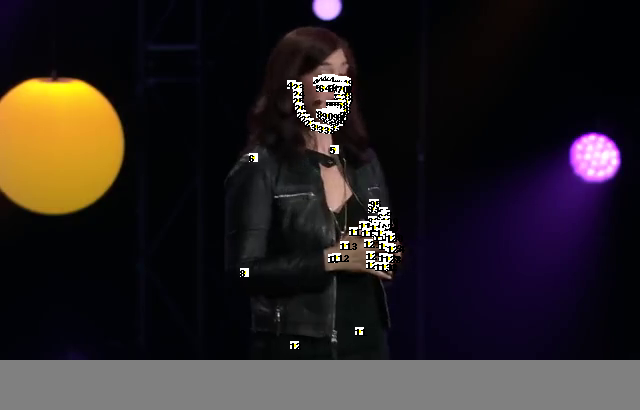

In [82]:
frame_id = 5
points = np.hstack((chunk_points[frame_id], chunk_scores[frame_id].reshape(-1, 1)))
show_me_points(video_path, frame_id, points, thr=0.4)

In [83]:
# Delete all kpts

# for i, r in tqdm(df_chunks.iterrows()):
#     out_kpts_path = os.path.join(chunks_ds, r.video_id, 'kpts', f'{r.clip_id}_{r.chunk_id}.pickle')
#     os.remove(out_kpts_path)



16534it [00:01, 11564.50it/s]


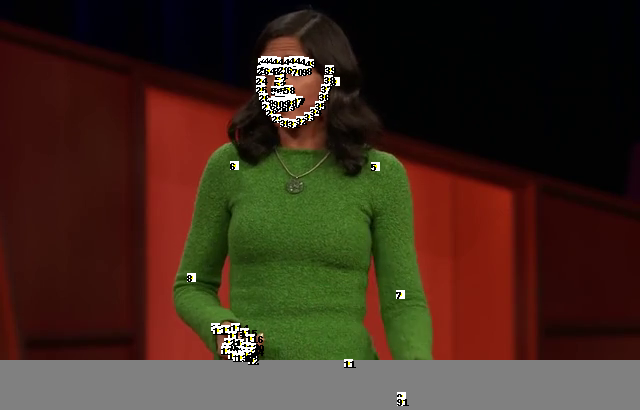

In [52]:
# /media/storage/datasets/youtube-gesture-dataset/TED_chunks_DS/chunks_ds/0bRocfcPhHU/video

video_id = '0bRocfcPhHU'
clip_id = 9
chunk_id = 1

video_path = os.path.join(chunks_ds, video_id, 'video', f'{clip_id}_{chunk_id}.mp4')
chunk_kpts_path = os.path.join(chunks_ds, video_id, 'kpts', f'{clip_id}_{chunk_id}.pickle')

with open(chunk_kpts_path, 'rb') as f:
    kpts_data = pickle.load(f)

chunk_points = [i['kpts'] for i in kpts_data]
chunk_scores = [i['scores'] for i in kpts_data]



frame_id = 12
points = np.hstack((chunk_points[frame_id], chunk_scores[frame_id].reshape(-1, 1)))
show_me_points(video_path, frame_id, points, thr=0.4)

In [ ]:
add_osd(video_path, chunk_points, chunk_scores, points_thr=0.4)

## Select points for kpts2tensor transformation

In [53]:
kpt_ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
brows_ids = [40, 42, 44, 45, 47, 49]
chin_ids = [23, 25, 27, 29, 31, 33, 35, 37, 39]
mouth_ids = [71, 74, 77, 80]


vis_points = kpt_ids + brows_ids + chin_ids + mouth_ids
len(vis_points)

30

In [73]:
points[[5,6]].mean(axis=-1)

array([180.78249855, 133.49431762])

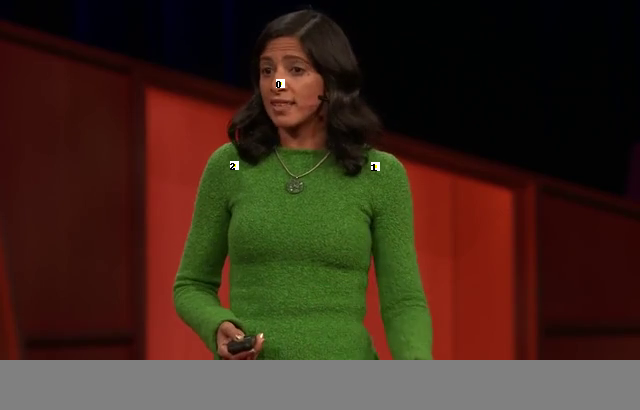

In [55]:
show_me_points(video_path, frame_id, points[[0,5, 6]], thr=0.4)

In [139]:
m = np.array([i[vis_points]for i in chunk_points])
m.shape

(100, 30, 2)

In [138]:
def normalize_kpts(points, shelter_ids=[5,6]):
    origins = points[:,shelter_ids,:].mean(axis=1, keepdims=True)
    norm_m = points - origins
    d = np.linalg.norm(norm_m[:, 5, :], axis=1, keepdims=True)
    norm_m = norm_m / np.expand_dims(d, axis=-1)
    norm_m = np.dot(norm_m, np.array([[1, 0], [0, -1]])) 
    return norm_m

In [141]:
norm_m = normalize_kpts(m, shelter_ids=[5,6])
norm_m.shape

(100, 30, 2)

In [143]:
norm_m[:, [0,5,6]][12]

array([[-0.34431951,  1.17214788],
       [ 0.99998366, -0.00571695],
       [-0.99998366,  0.00571695]])

In [144]:
# kpts2Tensor

kernel_size = 12

imu = torch.from_numpy(norm_m)
imu = imu.permute(2,1,0)
imu = torch.unsqueeze(imu, dim=0)
imu = imu.reshape(imu.size(0), imu.size(1), imu.size(-2)*imu.size(-1))
imu = imu.unfold(-1, kernel_size, kernel_size)
imu = imu.permute(0, 2, 1, 3)
imu = imu.reshape(imu.size(0), imu.size(1), -1)
imu.shape

torch.Size([1, 250, 24])